In [ ]:
# prompt: importa una carpeta de google drive de mi cuenta, llamada reto_life_clef
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/clef/

'Colab Notebooks'	  Rest-Mex_2025_test.xlsx    test.csv
 combined_data.xlsx	  Rest-Mex_2025_train.xlsx   validation.csv
 Iberlef_v4_final.ipynb   SemEval_v8.ipynb


In [ ]:
# spaCy y modelo en español
!pip install -U spacy
!python -m spacy download es_core_news_sm

# imbalanced-learn (para SMOTE, RandomOverSampler, etc.)
!pip install -U imbalanced-learn

# transformers (Hugging Face)
!pip install -U transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 46.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Procesamiento de datos y visualización
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# NLP
import re
import unicodedata
import spacy
import nltk
from nltk import TweetTokenizer
from nltk.util import ngrams
nlp = spacy.load("es_core_news_sm")

# Balanceo de clases
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import RandomUnderSampler

# Modelado y preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Deep Learning y Transformers
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from transformers import BertTokenizerFast
from transformers import BertForTokenClassification
from transformers import BertConfig
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

# Progreso
from tqdm import tqdm

In [ ]:

# [IMPORTS Y CONFIGURACIONES]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import unicodedata
import spacy
import nltk
from nltk import TweetTokenizer
from nltk.util import ngrams

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# Balanceo de clases
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import CondensedNearestNeighbour, RandomUnderSampler

# Modelado y preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
# Deep Learning y Transformers
from transformers import AutoConfig

# Deep Learning y Transformers
from transformers import BertTokenizerFast, BertForTokenClassification, BertConfig, AutoTokenizer, AutoModelForSequenceClassification

# Cargar el modelo de spaCy (asegúrate de tener instalado "es_core_news_sm")
nlp = spacy.load("es_core_news_sm")

# %% [CLASE DE PREPROCESAMIENTO]
class TextProcessing(object):
    name = 'Text Processing'
    lang = 'es'

    def __init__(self, lang: str = 'es'):
        self.lang = lang

    @staticmethod
    def load_spacy(lang: str) -> object:
        try:
            spacy_model = {'es': 'es_core_web_sm'}
            if not spacy.util.is_package(spacy_model[lang]):
                spacy.cli.download(spacy_model[lang])
            component = spacy.load(spacy_model[lang])
            return component
        except Exception as e:
            print('Error load spacy: {0}'.format(e))

    @staticmethod
    def proper_encoding(text: str) -> str:
        if not isinstance(text, str):
            return ''  # Return an empty string or handle it as needed
        try:
            text = unicodedata.normalize('NFD', text)
            text = text.encode('ascii', 'ignore')
            return text.decode("utf-8")
        except Exception as e:
            print('Error proper_encoding: {0}'.format(e))
            return text  # Return the original text in case of error

    @staticmethod
    def remove_patterns(text: str) -> str:
        if not isinstance(text, str):
            return ''  # Return an empty string or handle it as needed
        try:
            text = re.sub(r'\©|\×|\⇔|\_|\»|\«|\~|\#|\$|\€|\Â|\�|\¬', '', text)
            text = re.sub(r'\,|\;|\:|\!|\¡|\’|\‘|\”|\“|\"|\'|\`', '', text)
            text = re.sub(r'\}|\{|\[|\]|\(|\)|\<|\>|\?|\¿|\°|\|', '', text)
            text = re.sub(r'\/|\-|\+|\*|\=|\^|\%|\&|\$', '', text)
            text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text)
            return text.lower()
        except Exception as e:
            print('Error remove_patterns: {0}'.format(e))
            return text  # Return the original text in case of error

    @staticmethod
    def transformer(text: str, stopwords: bool = False) -> str:
        if not isinstance(text, str):
            return ''  # Return an empty string or handle it as needed
        try:
            text_out = TextProcessing.proper_encoding(text)
            text_out = text_out.lower()
            text_out = re.sub("[\U0001f000-\U000e007f]", '[EMOJI]', text_out)
            text_out = re.sub(
                r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)'
                r'(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+'
                r'(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))',
                '[URL]', text_out)
            text_out = re.sub("@([A-Za-z0-9_]{1,40})", '[MENTION]', text_out)
            text_out = re.sub("#([A-Za-z0-9_]{1,40})", '[HASTAG]', text_out)
            text_out = TextProcessing.remove_patterns(text_out)
            text_out = TextProcessing.stopwords(text_out) if stopwords else text_out
            text_out = re.sub(r'\s+', ' ', text_out).strip()
            return text_out if text_out != ' ' else None
        except Exception as e:
            print('Error transformer: {0}'.format(e))
            return text  # Return the original text in case of error



Entrenando Polarity...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Polarity - Epoch 1/4: 100%|██████████| 2858/2858 [34:24<00:00,  1.38it/s]


Polarity - Epoch 1/4 - Loss: 0.4469


Polarity - Epoch 2/4: 100%|██████████| 2858/2858 [34:24<00:00,  1.38it/s]


Polarity - Epoch 2/4 - Loss: 0.1736


Polarity - Epoch 3/4: 100%|██████████| 2858/2858 [34:24<00:00,  1.38it/s]


Polarity - Epoch 3/4 - Loss: 0.0971


Polarity - Epoch 4/4: 100%|██████████| 2858/2858 [34:24<00:00,  1.38it/s]


Polarity - Epoch 4/4 - Loss: 0.0562
Entrenando Type...
Número de etiquetas: 3


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
dccuchile/bert-base-spanish-wwm-uncased - Epoch 1/4: 100%|██████████| 875/875 [10:31<00:00,  1.39it/s]


dccuchile/bert-base-spanish-wwm-uncased - Epoch 1/4 - Loss: 0.1872


dccuchile/bert-base-spanish-wwm-uncased - Epoch 2/4: 100%|██████████| 875/875 [10:30<00:00,  1.39it/s]


dccuchile/bert-base-spanish-wwm-uncased - Epoch 2/4 - Loss: 0.0751


dccuchile/bert-base-spanish-wwm-uncased - Epoch 3/4: 100%|██████████| 875/875 [10:30<00:00,  1.39it/s]


dccuchile/bert-base-spanish-wwm-uncased - Epoch 3/4 - Loss: 0.0398


dccuchile/bert-base-spanish-wwm-uncased - Epoch 4/4: 100%|██████████| 875/875 [10:30<00:00,  1.39it/s]


dccuchile/bert-base-spanish-wwm-uncased - Epoch 4/4 - Loss: 0.0306


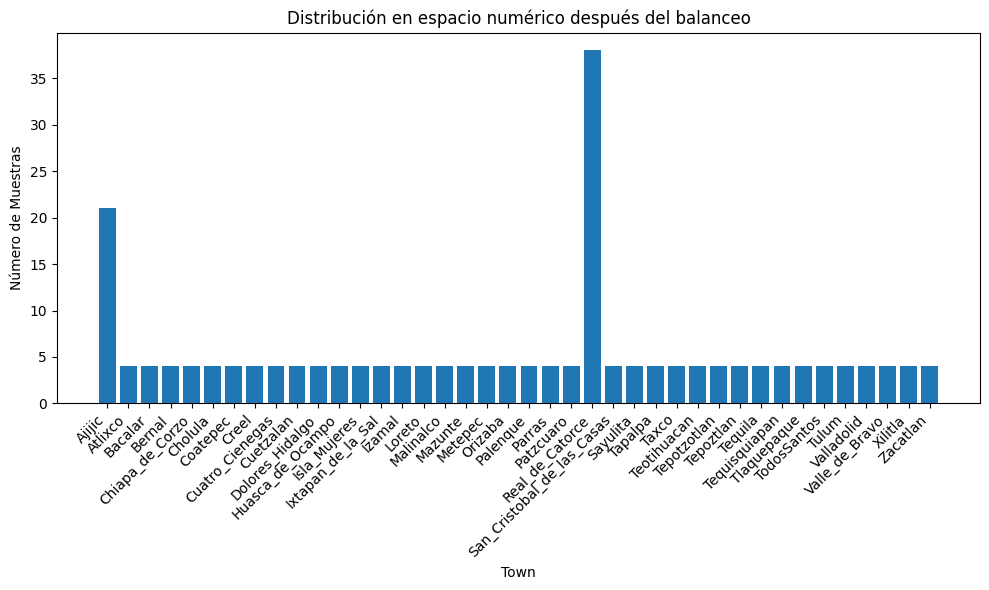

Entrenando Town...
Número de etiquetas: 40


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
dccuchile/bert-base-spanish-wwm-uncased - Epoch 1/4: 100%|██████████| 875/875 [10:31<00:00,  1.39it/s]


dccuchile/bert-base-spanish-wwm-uncased - Epoch 1/4 - Loss: 2.1411


dccuchile/bert-base-spanish-wwm-uncased - Epoch 2/4: 100%|██████████| 875/875 [10:31<00:00,  1.39it/s]


dccuchile/bert-base-spanish-wwm-uncased - Epoch 2/4 - Loss: 1.4050


dccuchile/bert-base-spanish-wwm-uncased - Epoch 3/4: 100%|██████████| 875/875 [10:31<00:00,  1.38it/s]


dccuchile/bert-base-spanish-wwm-uncased - Epoch 3/4 - Loss: 0.9377


dccuchile/bert-base-spanish-wwm-uncased - Epoch 4/4: 100%|██████████| 875/875 [10:32<00:00,  1.38it/s]


dccuchile/bert-base-spanish-wwm-uncased - Epoch 4/4 - Loss: 0.5331


Polarity - Predicting: 100%|██████████| 375/375 [01:38<00:00,  3.80it/s]
dccuchile/bert-base-spanish-wwm-uncased - Predicting: 100%|██████████| 375/375 [01:38<00:00,  3.80it/s]
dccuchile/bert-base-spanish-wwm-uncased - Predicting: 100%|██████████| 375/375 [01:38<00:00,  3.80it/s]


Predicciones en el conjunto de prueba:
   Polarity        Type          Town
0         4  Attractive  Isla_Mujeres
1         3       Hotel      Palenque
2         4       Hotel        Loreto
3         3  Attractive         Tulum
4         3       Hotel        Bernal
Archivo Excel 'predictions.xlsx' generado.

Métricas de Polarity:
Precisión (macro): 0.5826
Recall (macro): 0.5474
F1-score (macro): 0.5600

Métricas de Type:
Precisión (macro): 0.9604
Recall (macro): 0.9624
F1-score (macro): 0.9611

Métricas de Town:
Precisión (macro): 0.6019
Recall (macro): 0.4494
F1-score (macro): 0.4910

Métricas generales (promedio de las tareas):
Precisión general: 0.7149
Recall general: 0.6531
F1-score general: 0.6707


In [ ]:

# [CLASES Y FUNCIONES ORIGINALES]

# --- Dataset y Dataloader para Polarity ---
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, targets, tokenizer, max_length):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx]) if isinstance(self.texts, pd.Series) else str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        target = self.targets.iloc[idx] if hasattr(self.targets, 'iloc') else self.targets[idx]
        item['target'] = torch.tensor(target, dtype=torch.long)
        return item

def create_dataloader_sentiment(texts, targets, tokenizer, batch_size, max_length, shuffle=True):
    dataset = SentimentDataset(texts, targets, tokenizer, max_length)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


# --- Estimador personalizado para Polarity (BetoEstimator) con atención ---
class BetoEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, model_name="dccuchile/bert-base-spanish-wwm-uncased", device=None,
                 lr=2e-5, wd=0.01, num_epochs=2, batch_size=8, sentence_max_length=500):
        self.model_name = model_name
        self.device = device if device is not None else ("cuda" if torch.cuda.is_available() else "cpu")
        self.lr = lr
        self.wd = wd
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.sentence_max_length = sentence_max_length

    def fit(self, X, y):
        # --- activar salida de atenciones ---
        cfg = AutoConfig.from_pretrained(self.model_name, output_attentions=True)
        cfg.num_labels = 5
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name, config=cfg, ignore_mismatched_sizes=True
        ).to(self.device)

        train_loader = create_dataloader_sentiment(
            X, y, self.tokenizer, self.batch_size, self.sentence_max_length, shuffle=True
        )

        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.wd)
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        for epoch in range(self.num_epochs):
            epoch_loss = 0
            for batch in tqdm(train_loader, desc=f"Polarity - Epoch {epoch+1}/{self.num_epochs}"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                targets = batch['target'].to(self.device)
                optimizer.zero_grad()
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                # capturar atenciones si las necesitas:
                attentions = outputs.attentions
                logits = outputs.logits
                loss = loss_fn(logits, targets)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            avg_loss = epoch_loss / len(train_loader)
            print(f"Polarity - Epoch {epoch+1}/{self.num_epochs} - Loss: {avg_loss:.4f}")
        return self

    def predict(self, X):
        self.model.eval()
        loader = create_dataloader_sentiment(
            X, [0]*len(X), self.tokenizer, self.batch_size, self.sentence_max_length, shuffle=False
        )
        preds = []
        with torch.no_grad():
            for batch in tqdm(loader, desc="Polarity - Predicting"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                attentions = outputs.attentions
                logits = outputs.logits
                batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
                preds.extend(batch_preds)
        return np.array(preds)


# --- Dataset y Dataloader para Type y Town ---
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, targets, tokenizer, max_length):
        """
        texts: DataFrame con múltiples columnas. Se usa la columna "Combined" para tokenizar.
        targets: etiquetas numéricas.
        """
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx]['Combined'])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        target = self.targets.iloc[idx] if hasattr(self.targets, 'iloc') else self.targets[idx]
        item['target'] = torch.tensor(target, dtype=torch.long)
        return item

def create_dataloader_text(texts, targets, tokenizer, batch_size, max_length, shuffle=True):
    dataset = TextDataset(texts, targets, tokenizer, max_length)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


# --- Estimador personalizado para Type y Town (BERT con atención) ---
class BertTokenClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model_name="dccuchile/bert-base-spanish-wwm-uncased", device=None,
                 lr=2e-5, wd=0.01, num_epochs=2, batch_size=8, sentence_max_length=500):
        self.model_name = model_name
        self.device = device if device is not None else ("cuda" if torch.cuda.is_available() else "cpu")
        self.lr = lr
        self.wd = wd
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.sentence_max_length = sentence_max_length

    def fit(self, X, y):
        num_labels = len(np.unique(y))
        print("Número de etiquetas:", num_labels)

        # --- activar salida de atenciones y estados ocultos ---
        config = BertConfig.from_pretrained(
            self.model_name,
            output_attentions=True,
            output_hidden_states=True
        )
        config.num_labels = num_labels
        self.tokenizer = BertTokenizerFast.from_pretrained(self.model_name)
        self.model = BertForTokenClassification.from_pretrained(
            self.model_name,
            config=config,
            ignore_mismatched_sizes=True
        ).to(self.device)

        train_loader = create_dataloader_text(
            X, y, self.tokenizer, self.batch_size, self.sentence_max_length, shuffle=True
        )

        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.wd)
        loss_fn = nn.CrossEntropyLoss()

        self.model.train()
        for epoch in range(self.num_epochs):
            epoch_loss = 0
            for batch in tqdm(train_loader, desc=f"{self.model_name} - Epoch {epoch+1}/{self.num_epochs}"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                targets = batch['target'].to(self.device)
                optimizer.zero_grad()
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                attentions = outputs.attentions
                logits = outputs.logits[:, 0, :]
                loss = loss_fn(logits, targets)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            avg_loss = epoch_loss / len(train_loader)
            print(f"{self.model_name} - Epoch {epoch+1}/{self.num_epochs} - Loss: {avg_loss:.4f}")
        return self

    def predict(self, X):
        self.model.eval()
        loader = create_dataloader_text(
            X, [0]*len(X), self.tokenizer, self.batch_size, self.sentence_max_length, shuffle=False
        )
        preds = []
        with torch.no_grad():
            for batch in tqdm(loader, desc=f"{self.model_name} - Predicting"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                attentions = outputs.attentions
                logits = outputs.logits[:, 0, :]
                batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
                preds.extend(batch_preds)
        return np.array(preds)


# [MULTITASK PIPELINE: FUTURE UNION DE LAS TAREAS]
class MultiTaskPipeline(BaseEstimator):
    """
    Esta clase agrupa en paralelo las tres tareas:
      - Polarity: utilizando BetoEstimator con balanceo (con oversampling y undersampling)
      - Type: utilizando BertTokenClassifier y mapeo de etiquetas
      - Town: utilizando BertTokenClassifier con balanceo (mediante CondensedNearestNeighbour y SMOTE)
    """
    def __init__(self, polarity_estimator, type_estimator, town_estimator, type_mapping=None):
        self.polarity_estimator = polarity_estimator
        self.type_estimator = type_estimator
        self.town_estimator = town_estimator
        if type_mapping is None:
            self.type_mapping = {0: "Restaurant", 1: "Attractive", 2: "Hotel"}
        else:
            self.type_mapping = type_mapping

    def fit(self, X, y=None):
        # --- Pipeline para Polarity (balanceo idéntico) ---
        df_polarity = X[['Title', 'Review', 'Polarity']].copy()
        df_polarity['Combined'] = df_polarity['Title'].fillna('') + ' ' + df_polarity['Review'].fillna('')
        df_polarity['Polarity'] = df_polarity['Polarity'].replace([1,2,3,4,5], [0,1,2,3,4])
        X_pol = df_polarity['Combined']
        y_pol = df_polarity['Polarity']
        X_pol_arr = X_pol.values.reshape(-1, 1)
        ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
        X_pol_ros, y_pol_ros = ros.fit_resample(X_pol_arr, y_pol)
        rus = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
        X_pol_bal, y_pol_bal = rus.fit_resample(X_pol_ros, y_pol_ros)
        X_pol_bal = pd.Series(X_pol_bal.ravel())

        print("Entrenando Polarity...")
        self.polarity_estimator.fit(X_pol_bal, y_pol_bal)

        # --- Pipeline para Type (igual que original) ---
        df_type = X[['Title', 'Review', 'Town', 'Region', 'Type']].copy()
        df_type['Combined'] = df_type['Title'].fillna('') + ' ' + df_type['Review'].fillna('')
        label2id = {"Restaurant": 0, "Attractive": 1, "Hotel": 2}
        df_type['label'] = df_type['Type'].map(label2id)
        X_type = df_type[['Combined', 'Town', 'Region']]
        y_type = df_type['label']

        print("Entrenando Type...")
        self.type_estimator.fit(X_type, y_type)

        # --- Pipeline para Town (balanceo idéntico) ---
        df_town = X[['Title', 'Review', 'Town', 'Region', 'Type']].copy()
        df_town['Combined'] = df_town['Title'].fillna('') + ' ' + df_town['Review'].fillna('')
        y_town = df_town['Town']
        le_town = LabelEncoder()
        y_town_encoded = le_town.fit_transform(y_town)
        X_town = df_town[['Combined', 'Town', 'Region']]

        data_training = X_town.copy()
        data_training['Town'] = df_town['Town']
        le_town_bal = LabelEncoder()
        le_region = LabelEncoder()
        data_training['Town_encoded'] = le_town_bal.fit_transform(data_training['Town'])
        data_training['Region_encoded'] = le_region.fit_transform(data_training['Region'])
        data_training['Town_target'] = data_training['Town_encoded']
        X_numeric = data_training[['Town_encoded', 'Region_encoded']].values
        y_numeric = data_training['Town_target'].values
        undersampler = CondensedNearestNeighbour(n_neighbors=3, random_state=42)
        X_undersampled, y_undersampled = undersampler.fit_resample(X_numeric, y_numeric)
        oversampler = SMOTE(random_state=42, sampling_strategy="minority", k_neighbors=1)
        X_resampled, y_resampled = oversampler.fit_resample(X_undersampled, y_undersampled)
        decoded_towns = le_town_bal.inverse_transform(np.concatenate((y_undersampled, y_resampled)))
        unique_towns, counts = np.unique(decoded_towns, return_counts=True)
        plt.figure(figsize=(10,6))
        plt.bar(unique_towns, counts)
        plt.xlabel('Town')
        plt.ylabel('Número de Muestras')
        plt.title('Distribución en espacio numérico después del balanceo')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        print("Entrenando Town...")
        self.town_estimator.fit(X_town, y_town_encoded)
        self.le_town = le_town_bal

        return self

    def predict(self, X):
        # --- Predicción para Polarity ---
        df_polarity = X[['Title', 'Review', 'Polarity']].copy()
        df_polarity['Combined'] = df_polarity['Title'].fillna('') + ' ' + df_polarity['Review'].fillna('')
        X_pol = df_polarity['Combined']
        polarity_pred = self.polarity_estimator.predict(X_pol)

        # --- Predicción para Type ---
        df_type = X[['Title', 'Review', 'Town', 'Region', 'Type']].copy()
        df_type['Combined'] = df_type['Title'].fillna('') + ' ' + df_type['Review'].fillna('')
        X_type = df_type[['Combined', 'Town', 'Region']]
        type_pred = self.type_estimator.predict(X_type)
        type_pred_decoded = [self.type_mapping.get(pred, pred) for pred in type_pred]

        # --- Predicción para Town ---
        df_town = X[['Title', 'Review', 'Town', 'Region', 'Type']].copy()
        df_town['Combined'] = df_town['Title'].fillna('') + ' ' + df_town['Review'].fillna('')
        X_town = df_town[['Combined', 'Town', 'Region']]
        town_pred = self.town_estimator.predict(X_town)
        town_pred_decoded = self.le_town.inverse_transform(town_pred)

        predictions_df = pd.DataFrame({
            'Polarity': polarity_pred,
            'Type': type_pred_decoded,
            'Town': town_pred_decoded
        })
        return predictions_df


#  [ENTRENAMIENTO, PREDICCIÓN Y EXPORTACIÓN DE RESULTADOS]

# Cargar los datos (ajusta la ruta a tus datos)
data_path = '/content/drive/MyDrive/clef/Rest-Mex_2025_train.xlsx'
df_data = pd.read_excel(data_path)

# Muestreo (por ejemplo, 5000 registros)
df_muestra = df_data.sample(n=10000, random_state=42)
df = df_muestra.copy()

# Aplicar preprocesamiento a las columnas 'Review' y 'Title'
tp_en = TextProcessing(lang='en')
df['Review'] = df['Review'].apply(lambda x: tp_en.transformer(x))
df['Title'] = df['Title'].apply(lambda x: tp_en.transformer(x))

# Dividir en conjunto de entrenamiento (70%) y prueba (30%)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Instanciar cada estimador con los mismos parámetros de tu código original
polarity_estimator = BetoEstimator(
    model_name="dccuchile/bert-base-spanish-wwm-uncased",
    device=("cuda" if torch.cuda.is_available() else "cpu"),
    lr=2e-5,
    wd=0.01,
    num_epochs=4,
    batch_size=8,
    sentence_max_length=500
)

type_estimator = BertTokenClassifier(
    model_name="dccuchile/bert-base-spanish-wwm-uncased",
    device=("cuda" if torch.cuda.is_available() else "cpu"),
    lr=2e-5,
    wd=0.01,
    num_epochs=4,
    batch_size=8,
    sentence_max_length=500
)

town_estimator = BertTokenClassifier(
    model_name="dccuchile/bert-base-spanish-wwm-uncased",
    device=("cuda" if torch.cuda.is_available() else "cpu"),
    lr=2e-5,
    wd=0.01,
    num_epochs=4,
    batch_size=8,
    sentence_max_length=500
)

# Crear el pipeline multi-tarea
multi_pipeline = MultiTaskPipeline(
    polarity_estimator=polarity_estimator,
    type_estimator=type_estimator,
    town_estimator=town_estimator
)

# Entrenar el pipeline con el conjunto de entrenamiento
multi_pipeline.fit(train_df)

# Realizar predicciones en el conjunto de prueba
predictions_df = multi_pipeline.predict(test_df)
print("Predicciones en el conjunto de prueba:")
print(predictions_df.head())

# Exportar las predicciones a un archivo Excel
predictions_df.to_excel("predictions.xlsx", index=False)
print("Archivo Excel 'predictions.xlsx' generado.")

#  [CÁLCULO DE MÉTRICAS]

# Métricas para Polarity: convertir las etiquetas verdaderas de 1-5 a 0-4
y_true_polarity = test_df['Polarity'].replace({1:0, 2:1, 3:2, 4:3, 5:4}).values
y_pred_polarity = predictions_df['Polarity'].values
precision_polarity = precision_score(y_true_polarity, y_pred_polarity, average='macro')
recall_polarity = recall_score(y_true_polarity, y_pred_polarity, average='macro')
f1_polarity = f1_score(y_true_polarity, y_pred_polarity, average='macro')

# Métricas para Type (comparando etiquetas de texto)
y_true_type = test_df['Type'].values
y_pred_type = predictions_df['Type'].values
precision_type = precision_score(y_true_type, y_pred_type, average='macro', zero_division=0)
recall_type = recall_score(y_true_type, y_pred_type, average='macro', zero_division=0)
f1_type = f1_score(y_true_type, y_pred_type, average='macro', zero_division=0)

# Métricas para Town
y_true_town = test_df['Town'].values
y_pred_town = predictions_df['Town'].values
precision_town = precision_score(y_true_town, y_pred_town, average='macro', zero_division=0)
recall_town = recall_score(y_true_town, y_pred_town, average='macro', zero_division=0)
f1_town = f1_score(y_true_town, y_pred_town, average='macro', zero_division=0)

# Métricas generales (promedio de las tres tareas)
precision_overall = np.mean([precision_polarity, precision_type, precision_town])
recall_overall = np.mean([recall_polarity, recall_type, recall_town])
f1_overall = np.mean([f1_polarity, f1_type, f1_town])

print("\nMétricas de Polarity:")
print(f"Precisión (macro): {precision_polarity:.4f}")
print(f"Recall (macro): {recall_polarity:.4f}")
print(f"F1-score (macro): {f1_polarity:.4f}")

print("\nMétricas de Type:")
print(f"Precisión (macro): {precision_type:.4f}")
print(f"Recall (macro): {recall_type:.4f}")
print(f"F1-score (macro): {f1_type:.4f}")

print("\nMétricas de Town:")
print(f"Precisión (macro): {precision_town:.4f}")
print(f"Recall (macro): {recall_town:.4f}")
print(f"F1-score (macro): {f1_town:.4f}")

print("\nMétricas generales (promedio de las tareas):")
print(f"Precisión general: {precision_overall:.4f}")
print(f"Recall general: {recall_overall:.4f}")
print(f"F1-score general: {f1_overall:.4f}")

In [ ]:
# ─── CÁLCULO DE LA MÉTRICA MACRO‐AVERAGE GLOBAL ───
from sklearn.preprocessing import LabelEncoder

# 1) Polarity ya está en 0–4:
y_true_pol = y_true_polarity
y_pred_pol = y_pred_polarity

# 2) Encoder para los textos de Type
le_type = LabelEncoder().fit(
    np.concatenate([y_true_type, y_pred_type])
)
y_true_type_enc = le_type.transform(y_true_type)
y_pred_type_enc = le_type.transform(y_pred_type)

# 3) Encoder para los textos de Town
le_town_glob = LabelEncoder().fit(
    np.concatenate([y_true_town, y_pred_town])
)
y_true_town_enc = le_town_glob.transform(y_true_town)
y_pred_town_enc = le_town_glob.transform(y_pred_town)

# 4) Concatenar todas las verdaderas y predichas
y_true_all = np.concatenate([y_true_pol, y_true_type_enc, y_true_town_enc])
y_pred_all = np.concatenate([y_pred_pol, y_pred_type_enc, y_pred_town_enc])

# 5) Calcular macro‐average global
precision_global = precision_score(y_true_all, y_pred_all, average='macro', zero_division=0)
recall_global    = recall_score  (y_true_all, y_pred_all, average='macro', zero_division=0)
f1_global        = f1_score      (y_true_all, y_pred_all, average='macro', zero_division=0)

print("\nMétricas globales (macro-average):")
print(f"Precisión macro: {precision_global:.4f}")
print(f"Recall    macro: {recall_global:.4f}")
print(f"F1-score  macro: {f1_global:.4f}")


Métricas globales (macro-average):
Precisión macro: 0.6323
Recall    macro: 0.4921
F1-score  macro: 0.5301


In [ ]:
# ===============================
# GUARDAR MODELO ENTRENADO .PKL
# ===============================
import joblib

joblib.dump(multi_pipeline, '/content/drive/MyDrive/clef/modelo_entrenado_multitarea.pkl')
print("Modelo guardado exitosamente en la carpeta)




Modelo guardado exitosamente en la carpeta 'clef'
